In [75]:
import sys
sys.path.append('.')

In [2]:
import pandas as pd
import re
import numpy as np
import nltk
import emoji
import collections
from bpe import Encoder
import gensim
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
import math
import json
import os
from underthesea import word_tokenize
from emoticons import EMOTICONS

In [255]:
consonants = ['b', 'c', 'd', 'đ', 'g', 'h', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'x']
vowels = ['a', 'ă', 'â', 'e', 'ê', 'i', 'o', 'ô', 'ơ', 'u', 'ư', 'y',
          'à', 'ằ', 'ầ', 'è', 'ề', 'ì', 'ò', 'ồ', 'ờ', 'ù', 'ừ', 'ỳ',
          'á', 'ắ', 'ấ', 'é', 'ế', 'í', 'ó', 'ố', 'ớ', 'ú', 'ứ', 'ý',
          'ạ', 'ặ', 'ậ', 'ẹ', 'ệ', 'ị', 'ọ', 'ộ', 'ợ', 'ụ', 'ự', 'ỵ',
          'ẵ', 'ẵ', 'ẫ', 'ẽ', 'ễ', 'ĩ', 'õ', 'ỗ', 'ỡ', 'ũ', 'ữ', 'ỹ',
          'ả', 'ẳ', 'ẩ', 'ẻ', 'ể', 'ỉ', 'ỏ', 'ổ', 'ở', 'ủ', 'ử', 'ỷ']
prefixes = ['ch', 'gh', 'kh', 'ng', 'ngh', 'nh', 'ph', 'th', 'tr']
subfixes = ['ng', 'nh', 'm', 'n', 't']

def no_accent_vietnamese(s):
    s = re.sub('[áàảãạăắằẳẵặâấầẩẫậ]', 'a', s)
    s = re.sub('[ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬ]', 'A', s)
    s = re.sub('[éèẻẽẹêếềểễệ]', 'e', s)
    s = re.sub('[ÉÈẺẼẸÊẾỀỂỄỆ]', 'E', s)
    s = re.sub('[óòỏõọôốồổỗộơớờởỡợ]', 'o', s)
    s = re.sub('[ÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢ]', 'O', s)
    s = re.sub('[íìỉĩị]', 'i', s)
    s = re.sub('[ÍÌỈĨỊ]', 'I', s)
    s = re.sub('[úùủũụưứừửữự]', 'u', s)
    s = re.sub('[ÚÙỦŨỤƯỨỪỬỮỰ]', 'U', s)
    s = re.sub('[ýỳỷỹỵ]', 'y', s)
    s = re.sub('[ÝỲỶỸỴ]', 'Y', s)
    s = re.sub('đ', 'd', s)
    s = re.sub('Đ', 'D', s)
    return s

def find_accent_vietnamese(line):
    if re.findall('[áàảãạăắằẳẵặâấầẩẫậ]', line) != []:
        return True
    elif re.findall('[ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬ]', line) != []:
        return True
    elif re.findall('[éèẻẽẹêếềểễệ]', line) != []:
        return True
    elif re.findall('[ÉÈẺẼẸÊẾỀỂỄỆ]', line) != []:
        return True
    elif re.findall('[óòỏõọôốồổỗộơớờởỡợ]', line) != []:
        return True
    elif re.findall('[ÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢ]', line) != []:
        return True
    elif re.findall('[íìỉĩị]', line) != []:
        return True
    elif re.findall('[ÍÌỈĨỊ]', line) != []:
        return True
    elif re.findall('[úùủũụưứừửữự]', line) != []:
        return True
    elif re.findall('[ÚÙỦŨỤƯỨỪỬỮỰ]', line) != []:
        return True
    elif re.findall('[ýỳỷỹỵ]', line) != []:
        return True
    elif re.findall('[ÝỲỶỸỴ]', line) != []:
        return True
    elif re.findall('đ', line) != []:
        return True
    elif re.findall('Đ', line) != []:
        return True
    return False

def reformat_unicode(line):
    line = re.sub('à', 'à', line) # a\xcc\x80 -> \xc3\xa0
    line = re.sub('ằ', 'ằ', line) # \xc4\x83\xcc\x80 -> \xe1\xba\xb1
    line = re.sub('ầ', 'ầ', line) # \xc3\xa2\xcc\x80 -> \xe1\xba\xa7
    line = re.sub('è', 'è', line) # e\xcc\x80 -> \xe1\xba\xb9
    line = re.sub('ề', 'ề', line) # \xc3\xaa\xcc\x80 -> \xe1\xbb\x81
    line = re.sub('ò', 'ò', line) # o\xcc\x80 -> \xc3\xb2
    line = re.sub('ồ', 'ồ', line) # \xc3\xb4\xcc\x80 -> \xe1\xbb\x93
    line = re.sub('ờ', 'ờ', line) # \xc6\xa1\xcc\x80 -> \xe1\xbb\x9d
    line = re.sub('ì', 'ì', line) # i\xcc\x80 -> \xc3\xac
    line = re.sub('ù', 'ù', line) # u\xcc\x80 -> \xc3\xb9
    line = re.sub('ừ', 'ừ', line) # \xc6\xb0\xcc\x80 -> \xe1\xbb\xab
    line = re.sub('ỳ', 'ỳ', line) # y\xcc\x80 -> \xe1\xbb\xb3
    
    line = re.sub('á', 'á', line) # a\xcc\x81 -> \xc3\xa1
    line = re.sub('ắ', 'ắ', line) # \xc4\x83\xcc\x81 -> \xe1\xba\xaf
    line = re.sub('ấ', 'ấ', line) # \xc3\xa2\xcc\x81 -> \xe1\xba\xa5
    line = re.sub('é', 'é', line) # e\xcc\x81 -> \xc3\xa9
    line = re.sub('ế', 'ế', line) # \xc3\xaa\xcc\x81 -> \xe1\xba\xbf
    line = re.sub('ó', 'ó', line) # o\xcc\x81 -> \xc3\xb3
    line = re.sub('ố', 'ố', line) # \xc3\xb4\xcc\x81 -> \xe1\xbb\x91
    line = re.sub('ớ', 'ớ', line) # \xc6\xa1\xcc\x81 -> \xe1\xbb\x9b
    line = re.sub('í', 'í', line) # i\xcc\x81 -> \xc3\xad
    line = re.sub('ú', 'ú', line) # u\xcc\x81 -> \xc3\xba
    line = re.sub('ứ', 'ứ', line) # \xc6\xb0\xcc\x81 -> \xe1\xbb\xa9
    line = re.sub('ý', 'ý', line) # y\xcc\x81 -> \xc3\xbd
    
    line = re.sub('ả', 'ả', line) # a\xcc\x89 -> \xe1\xba\xa3
    line = re.sub('ẳ', 'ẳ', line) # \xc4\x83\xcc\x89 -> \xe1\xba\xb3
    line = re.sub('ẩ', 'ẩ', line) # \xc3\xa2\xcc\x89 -> \xe1\xba\xa9
    line = re.sub('ẻ', 'ẻ', line) # e\xcc\x89 -> \xe1\xba\xbb
    line = re.sub('ể', 'ể', line) # \xc3\xaa\xcc\x89 -> \xe1\xbb\x83
    line = re.sub('ỏ', 'ỏ', line) # o\xcc\x89 -> \xe1\xbb\x8f
    line = re.sub('ổ', 'ổ', line) # \xc3\xb4\xcc\x89 -> \xe1\xbb\x95
    line = re.sub('ở', 'ở', line) # \xc6\xa1\xcc\x89 -> \xe1\xbb\x9f
    line = re.sub('ỉ', 'ỉ', line) # i\xcc\x89 -> \xe1\xbb\x89
    line = re.sub('ủ', 'ủ', line) # u\xcc\x89 -> \xe1\xbb\xa7
    line = re.sub('ử', 'ử', line) # \xc6\xb0\xcc\x89 -> \xe1\xbb\xad
    line = re.sub('ỷ', 'ỷ', line) # y\xcc\x89 -> \xe1\xbb\xb7
    
    line = re.sub('ã', 'ã', line) # a\xcc\x83 -> \xc3\xa3
    line = re.sub('ẵ', 'ẵ', line) # \xc4\x83\xcc\x83 -> \xe1\xba\xb5
    line = re.sub('ẫ', 'ẫ', line) # \xc3\xa2\xcc\x83 -> \xe1\xba\xab
    line = re.sub('ẽ', 'ẽ', line) # e\xcc\x83 -> \xe1\xba\xbd
    line = re.sub('ễ', 'ễ', line) # \xc3\xaa\xcc\x83 -> \xe1\xbb\x85
    line = re.sub('õ', 'õ', line) # o\xcc\x83 -> \xc3\xb5
    line = re.sub('ỗ', 'ỗ', line) # \xc3\xb4\xcc\x83 -> \xe1\xbb\x97
    line = re.sub('ỡ', 'ỡ', line) # \xc6\xa1\xcc\x83 -> \xe1\xbb\xa1
    line = re.sub('ĩ', 'ĩ', line) # i\xcc\x83 -> \xc4\xa9
    line = re.sub('ũ', 'ũ', line) # u\xcc\x83 -> \xc5\xa9
    line = re.sub('ữ', 'ữ', line) # \xc6\xb0\xcc\x83 -> \xe1\xba\xb5
    line = re.sub('ỹ', 'ỹ', line) # y\xcc\x83 -> \xe1\xbb\xb9
    
    line = re.sub('ạ', 'ạ', line) # a\xcc\xa3 -> \xe1\xba\xa1
    line = re.sub('ặ', 'ặ', line) # \xc4\x83\xcc\xa3 -> \xe1\xba\xb7
    line = re.sub('ậ', 'ậ', line) # \xc3\xa2\xcc\xa3 -> \xe1\xba\xad
    line = re.sub('ẹ', 'ẹ', line) # e\xcc\xa3 -> \xe1\xba\xb9
    line = re.sub('ệ', 'ệ', line) # \xc3\xaa\xcc\xa3 -> \xe1\xbb\x87
    line = re.sub('ọ', 'ọ', line) # o\xcc\xa3 -> \xe1\xbb\x8d
    line = re.sub('ộ', 'ộ', line) # \xc3\xb4\xcc\xa3 -> \xe1\xbb\x99
    line = re.sub('ợ', 'ợ', line) # \xc6\xa1\xcc\xa3 -> \xe1\xbb\xa3
    line = re.sub('ị', 'ị', line) # i\xcc\xa3 -> \xe1\xbb\x8b
    line = re.sub('ụ', 'ụ', line) # u\xcc\xa3 -> \xe1\xbb\xa5
    line = re.sub('ự', 'ự', line) # \xc6\xb0\xcc\xa3 -> \xe1\xbb\xb1
    line = re.sub('ỵ', 'ỵ', line) # y\xcc\xa3 -> \xe1\xbb\xb5
    
    return line



In [245]:
PUNCT_CHAR = r'([!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~])' # r'["\'./,#$%&~{|}[\]`+]'
punct = re.compile(PUNCT_CHAR)

DIGIT_WITH_CHAR = r'([a-zA-Z]*)(\d+)([a-zA-Z]*)'
digit_char = re.compile(DIGIT_WITH_CHAR)

URL = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
url = re.compile(URL)

DATE = r"([\d]{1,2}[/.-])?[\d]{1,2}[/.-][\d]{4}"
date = re.compile(DATE)

def lowercase(data):
    return [line.lower() for line in data]

def remove_punct_char(data):
    return [punct.sub(' ', line) for line in data] 

def remove_accent(data):
    return [no_accent_vietnamese(line) for line in data]

def remove_date(data):
    return [date.sub('', line) for line in data]

def replace_emoticons(line):
    for reg, meanings in EMOTICONS.items():
        line = re.sub(reg, meanings, line)
    return line

def reformat_text(data):
    data = [reformat_unicode(line) for line in data]
    return [replace_emoticons(line) for line in data]

def remove_url(data):
    return [url.sub('', line) for line in data]

def remove_digit_char(data):
    return [digit_char.sub('', line) for line in data]

def strip_duplicate_char(word):
    if len(word) == 1:
        return word
    # Strip duplicate char at the end
    last_word = word[-1]
    word = word.rstrip(f'{last_word}')
    word = word + last_word
    # Strip duplicate char at the begining
    first_word = word[0]
    word = word.lstrip(f'{first_word}')
    word = first_word + word
    return word

def strip_head_tail(line):
    line = line.strip()
    return ' '.join([strip_duplicate_char(word) for word in line.split()])

def strip(data):
    return [strip_head_tail(line) for line in data]

def split_emoji(line):
    split_text = emoji.get_emoji_regexp().split(line)
    return [i for i in split_text if i != '' and i != '️'] # <= the second is for red-heart emoji

def remove_miss_type(word):
    for consonant in consonants:
        for prefix in prefixes:
            if prefix == 'ng' and consonant == 'h':
                continue
            word = re.sub(f'{prefix}{consonant}', f'{prefix}', word)
        for subfix in subfixes:
            word = re.sub(f'{consonant}{subfix}', f'{subfix}', word)
    
    for consonant in [instance for instance in consonants if instance not in subfixes]:
        for vowel in vowels:
            sub = ''
            if consonant == 'g':
                sub = 'ng'
            if consonant == 'h':
                sub = 'nh'
            word = re.sub(f'{vowel}{consonant}', vowel+sub, word)
        
    return word

def remove_telex_error_in_word(word):
    word = re.sub('[wfjz]', '', word)
    if re.findall('[a-z]s', word):
        word = re.sub('s', '', word)
    if re.findall('[a-z]x', word):
        word = re.sub('x', '', word)
    
    return remove_miss_type(word)

def error_correction_in_line(line):
    return ' '.join([remove_telex_error_in_word(word) for word in line.split()])

def error_correction(data):
    data = [error_correction_in_line(line) for line in data]
    return data

In [177]:
def get_vocab(data):
    vocab = collections.defaultdict(int)
    data = [split_emoji(i) for i in data]
    for sent_emoji in data:
        for each in sent_emoji:
            for word in each.split():
                vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

def add_end_token(line):
    line = split_emoji(line)
    new_arr = []
    for each in line:
        for word in each.split():
            new_arr.append(word + '</w>')
    return ' '.join([word for word in new_arr])

def get_stats(vocab):
        pairs = collections.defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pairs[symbols[i],symbols[i+1]] += freq
        return pairs
    
def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

def get_tokens_from_vocab(vocab):
    tokens_frequencies = collections.defaultdict(int)
    vocab_tokenization = {}
    for word, freq in vocab.items():
        word_tokens = word.split()
        for token in word_tokens:
            tokens_frequencies[token] += freq
        vocab_tokenization[''.join(word_tokens)] = word_tokens
    return tokens_frequencies, vocab_tokenization

def get_tokens(vocab):
    tokens = collections.defaultdict(int)
    for word, freq in vocab.items():
        word_tokens = word.split(' ')
        for token in word_tokens:
            tokens[token] += freq
    return tokens

def measure_token_length(token):
    if token[-4:] == '</w>':
        return len(token[:-4]) + 1
    else:
        return len(token)

class BPETokenizer():
    def __init__(self, number_merge=1000, unknown_token='</u>'):
        self.number_merge = number_merge
        self.unknown_token = unknown_token
        
    def fit(self, data):
        vocab = get_vocab(data)
        for _ in range(self.number_merge):
            pairs = get_stats(vocab)
            if not pairs:
                break
            best_pair = max(pairs, key=pairs.get)
            vocab = merge_vocab(best_pair, vocab)
        self.tokens_frequencies, self.vocab_tokenization = get_tokens_from_vocab(vocab)
        self.sorted_tokens_tuple = sorted(self.tokens_frequencies.items(), key=lambda item: (measure_token_length(item[0]), item[1]), reverse=True)
        self.sorted_tokens = [token for (token, freq) in self.sorted_tokens_tuple]
        
    def tokenize(self, string, sorted_tokens):
        if string == '':
            return []
        if self.sorted_tokens == []:
            return [self.unknown_token]
        
        string_tokens = []
        is_tokenized = False
        for i in range(len(sorted_tokens)):
            token = sorted_tokens[i]
            token_reg = re.escape(token.replace('.', '[.]'))

            matched_positions = [(m.start(0), m.end(0)) for m in re.finditer(token_reg, string)]
            if len(matched_positions) == 0:
                continue

            substring_end_positions = [matched_position[0] for matched_position in matched_positions]
            
            substring_start_position = 0
            for substring_end_position in substring_end_positions:
                substring = string[substring_start_position:substring_end_position]
                string_tokens += self.tokenize(string=substring, sorted_tokens=sorted_tokens[i+1:])
                string_tokens += [token]
                substring_start_position = substring_end_position + len(token)
            remaining_substring = string[substring_start_position:]
            string_tokens += self.tokenize(string=remaining_substring, sorted_tokens=sorted_tokens[i+1:])
            break
            
        return string_tokens
    
    
    def tokenize_word(self, string):
        string = add_end_token(string)
        return self.tokenize(string, self.sorted_tokens)




In [178]:
def label(star):
    label = []
    for i in star:
        if i == 5 or i == 4:
            label.append('POS')
        elif i == 3:
            label.append('NEU')
        else:
            label.append('NEG')
    return label

def add_no_accent(data, label=None, random_state=52):
    no_accent = remove_accent(data)
    for i, sent in enumerate(data):
        if find_accent_vietnamese(sent):
            no_accent += [sent]
            if label:
                label += [label[i]]
    new_data = np.array(no_accent)
    new_label = np.array(label)
    
    np.random.seed(random_state)
    permutation = np.random.permutation(len(no_accent))
    new_data = new_data[permutation]
    
    if label:
        new_label = new_label[permutation]
        return new_data.tolist(), new_label.tolist()
    else:
        return new_data.tolist()

def remove_stopwords(data, stopwords):
    new_data = []
    for sent in data:
        sent = word_tokenize(sent, format='text')
        sent = [word for word in sent.split() if word not in stopwords]
        new_data.append(re.sub('_', ' ', ' '.join(sent)))
        break

    return new_data
    
def drop_uncommon_character(data, exception):
    new_data = []
    for sent in data:
        sent = [re.sub(r'/d+', '', word) for word in sent if (len(word) > 1 or 
                (word in exception) or
                (emoji.get_emoji_regexp().findall(word) != []))]
        new_data.append(sent)
    return new_data

In [179]:
def tokenize(data, encoder):
    data = [encoder.tokenize(i) for i in data]
    return drop_uncommon_character(remove_eow_sow(data), ['k', 'ạ'])
    
def remove_eow_sow(data):
    new_data = []
    for sent in data:
        sent = [word for word in sent if word not in ['__eow', '__sow']]
        new_data.append(sent)
    return new_data

def add_padding(data, max_length=64, padding='__pad'):
    new_data = []
    for sent in data:
        if len(sent) > max_length:
            sent = sent[:max_length]
        else:
            sent += [padding]*(max_length - len(sent))
        new_data.append(sent)
    
    return new_data

def word2vec_embedding(data, model):
    new_data = []
    for sent in data:
        sent_len = len(sent)
        if sent_len == 0:
            word_vec = np.array(model.wv['__unk'])
        else:
            word_vec = np.zeros(model.vector_size)
            for word in sent:
                word_vec += np.array(model.wv[word if word in model.wv.index_to_key else '__unk'])
            word_vec = word_vec / sent_len
        new_data.append(word_vec)
    return np.array(new_data)

def create_vocab(data, min_feq=0):
    vocab = collections.defaultdict(int)
    for sent in data:
        for word in sent:
            vocab[word] += 1
    vocab = {k: v for k, v in vocab.items() if v >= min_feq}
    return {k : i for i, (k, v) in enumerate(vocab.items())}


def bow_vectorize(data, vocab):
    vocab_size = len(vocab)
    n_dim = len(data)
    new_data = np.zeros((n_dim, vocab_size))
    idf = np.zeros((n_dim, vocab_size))
    for line, sent in enumerate(data):
        for word in sent:
            x, y = line, vocab.get(word)
            if y:
                new_data[x, y] += 1
    return new_data

def tf_idf_vectorize(data, vocab):
    vocab_size = len(vocab)
    n_dim = len(data)
    new_data = np.zeros((n_dim, vocab_size))
    idf = np.zeros((n_dim, vocab_size))
    for line, sent in enumerate(data):
        sent_len = len(sent)
        for word in sent:
            x, y = line, vocab.get(word)
            if y:
                new_data[x, y] += 1
            idf[x, y] = 1
    idf = idf.sum(axis=0)
    with np.errstate(divide='ignore'):
        idf = np.where(idf == 0, 0, np.log(n_dim / idf))
    new_data = new_data * idf
    return new_data

In [8]:
raw_data = pd.read_csv('./data.csv')

In [9]:
raw_data.dropna(inplace=True)

In [246]:
def remove_empty(data, label):
    for i, sent in enumerate(data):
        if sent == '':
            data.pop(i)
            label.pop(i)
    return data, label

def preprocess(data):
    data_arr = lowercase(data)
    data_arr = reformat_text(data_arr)
    data_arr = remove_url(data_arr)
    data_arr = remove_date(data_arr)
    data_arr = error_correction(data_arr)
    data_arr = remove_punct_char(data_arr)
    data_arr = remove_digit_char(data_arr)
    data_arr = strip(data_arr)
    return data_arr

def split_train_test(content, star, n_splits=1, test_size=0.2, random_state=52):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=52)
    for train_index, test_index in split.split(content, star):
        content = np.array(content)
        star = np.array(star)
        content_train, content_test  = content[train_index].tolist(), content[test_index].tolist()
        star_train, star_test = star[train_index].tolist(), star[test_index].tolist()
        
    return content_train, content_test, star_train, star_test

In [180]:
content, star = raw_data.content, raw_data.start

In [181]:
content = content.to_list()
star = star.to_list()

In [182]:
content_train, content_test, star_train, star_test = split_train_test(content, star)

In [183]:
content_train = preprocess(content_train)
content_test = preprocess(content_test)

In [184]:
content_train, star_train = remove_empty(content_train, star_train)

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, vocab_size=2000, pct_bpe=1, ngram_min=2, ngram_max=7, min_feq=5, exceptions=['k', 'ạ'], return_vocab=False):
        self.vocab_size = vocab_size
        self.pct_bpe = pct_bpe
        self.ngram_min = ngram_min
        self.ngram_max = ngram_max
        self.min_feq = min_feq
        self.return_vocab = return_vocab
        self.exceptions = exceptions
    
    def fit(self, X, y=None):
#         print('token fit call')
        self.encoder = Encoder(self.vocab_size,
                               pct_bpe=self.pct_bpe,
                               ngram_min=self.ngram_min,
                               ngram_max=self.ngram_max)
        self.encoder.fit(X)
        token = drop_uncommon_character(tokenize(X, self.encoder), self.exceptions)
        return self
    
    def transform(self, X, *args, **kwargs):
#         print('token transfrom call')
        token = tokenize(X, self.encoder)
        if self.return_vocab:
            return token, self.encoder.bpe_vocab
        else:
            return token

    
class WithoutStopWord(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords):
        self.stopwords = stopwords
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, *args, **kwargs):
        data, vocab = X
        data = remove_stopwords(data, self.stopwords)
    
        vocab = {k : v for k, v in vocab.items() if k not in self.stopwords}
        vocab = {k : i for i, (k, v) in enumerate(vocab.items())}
        
        return data
        
    
class Padding(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=20):
        self.max_length = max_length
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, *args, **kwargs): 
        data, vocab = X
        return add_padding(data, self.max_length)
    
class BowVectorizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.vocab = create_vocab(X)
        return self
    
    def transform(self, X, *args, **kwargs):
        return bow_vectorize(X, self.vocab)
        
class TfIdfVectorizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
#         print('tf fit call')
        self.vocab = create_vocab(X)
        return self
    
    def transform(self, X, *args, **kwargs):
#         print('tf transform call')
        return tf_idf_vectorize(X, self.vocab)

        
class W2VEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self,  vector_size=100, min_count=5, sg=True, hs=True, window=10, workers=4):
        self.vector_size = vector_size
        self.min_count = min_count
        self.sg = sg
        self.hs = hs
        self.window = window
        self.workers = workers
        
    def fit(self, X, y=None):
        self.model = gensim.models.Word2Vec(X,
                                            vector_size=self.vector_size,
                                            min_count=self.min_count,
                                            sg=self.sg,
                                            hs=self.hs,
                                            window=self.window,
                                            workers=self.workers)
        return self
    
    def transform(self, X, *args, **kwargs):
        return word2vec_embedding(X, self.model)

    
class Unique(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        self.training = True
        self.X, self.y = unique(X, y)
        return self
    
    def transform(self, X):
        if self.training:
            self.training = False
            return self.X, self.y
        else:
            return X

class ReportResult(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_name):
        self.estimator_name = estimator_name
        
    def fit(self, X, y=None):
        self.predict_label = label(X)
        self.true_label = label(y)
        return self

    def transform(self, X):
        report = classification_report(self.predict_label, self.true_label, output_dict=False)
#         if not os.path.exists('report.json'):
#             with open('report.json', 'w') as f:
#                 json.dump({self.estimator_name : [report]}, f)
#         else:            
#             with open('report.json', 'r') as f:
#                 data = json.load(f)
#                 data[self.estimator_name].append(report)
#                 json.dumps(data)
        return report
        

In [43]:
def unique(data, label):
    data = np.array(data)
    label = np.array(label)
    data_arr = np.c_[data, label]
    data_arr = np.unique(data_arr, axis=0)
    return data_arr[:,:-1], data_arr[:,-1]

In [19]:
def load_stopwords():
    with open('./stopwords-dash.txt', 'r') as f:
        lines = f.readlines()
        stopwords = [line[:-1] for line in lines if ' ' not  in line]
    return stopwords

In [ ]:
stopwords = load_stopwords()
stopwords

In [185]:
content_train, star_train = add_no_accent(content_train, star_train)

In [69]:
from sklearn.utils import resample
def upsample(data, label):
    data = np.array(data)
    label = np.array(label)
    data_arr = np.c_[data, label]
    label = data_arr[:, 1]
    pos_label = (label == '4') | (label == '5')
    neu_label = label == '3'
    neg_label = (label == '1') | (label == '2')
    pos_data = resample(data_arr[pos_label], replace=True, n_samples=len(pos_label), random_state=52)
    neu_data = resample(data_arr[neu_label], replace=True, n_samples= int(len(pos_label)), random_state=52)
    neg_data = resample(data_arr[neg_label], replace=True, n_samples=int(len(pos_label)), random_state=52)
    
    data_arr = np.concatenate((pos_data, neu_data, neg_data))
    data_arr = np.random.permutation(data_arr)
    return data_arr[:, 0].tolist(), data_arr[: ,1].astype(np.int8).tolist()

In [168]:
content_train, star_train = upsample(content_train, star_train)

In [186]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
bow_processing = Pipeline([('tokenizer', Tokenizer(8192, 0.5)), ('vectorizer', BowVectorizer())])
tf_idf_processing = Pipeline([('tokenizer', Tokenizer(6800, 0.8)), ('vectorizer', TfIdfVectorizer())])
w2v_processing = Pipeline([('tokenizer', Tokenizer(3500, 0.7)), ('embedding', W2VEmbedding(vector_size=1000))])

In [ ]:
from sklearn.cluster import KMeans
kmeans = Pipeline([('tokenizer', Tokenizer(3500, 0.7)), ('embedding', TfIdfEmbedding()), ('cluster', KMeans(n_clusters=5, random_state=52))])
kmeans.fit(content_train, content_test)

In [ ]:
report = ReportResult('Kmean')
print(report.fit_transform(kmeans.predict(content_test), star_test))

In [187]:
X_train = tf_idf_processing.fit_transform(content_train)
X_test = tf_idf_processing.transform(content_test)
y_train = np.array(star_train)
y_test = np.array(star_test)

In [188]:
from sklearn.naive_bayes import MultinomialNB
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB()

In [189]:
report = ReportResult('MultiNB')
X_test = tf_idf_processing.transform(content_test)
print(report.fit_transform(multi_nb.predict(X_test), y_test))

              precision    recall  f1-score   support

         NEG       0.72      0.60      0.66      1588
         NEU       0.30      0.33      0.32       857
         POS       0.84      0.88      0.86      3843

    accuracy                           0.73      6288
   macro avg       0.62      0.60      0.61      6288
weighted avg       0.73      0.73      0.73      6288



In [139]:
from sklearn.naive_bayes import BernoulliNB
bernoulli_nb = Pipeline([('feature_processing', bow_processing), ('estimator', BernoulliNB())])
bernoulli_nb.fit(content_train, star_train)

Pipeline(steps=[('feature_processing',
                 Pipeline(steps=[('tokenizer',
                                  Tokenizer(pct_bpe=0.5, vocab_size=8192)),
                                 ('embedding', BowEmbedding())])),
                ('estimator', BernoulliNB())])

In [141]:
report = ReportResult('BernoulliNB')
print(report.fit_transform(bernoulli_nb.predict(content_test), star_test))

              precision    recall  f1-score   support

         NEG       0.56      0.63      0.60      1189
         NEU       0.38      0.34      0.36      1049
         POS       0.85      0.85      0.85      4050

    accuracy                           0.72      6288
   macro avg       0.60      0.61      0.60      6288
weighted avg       0.72      0.72      0.72      6288



In [190]:
from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression(max_iter=2000)
logistic_clf.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [191]:
report = ReportResult('Softmax')
print(report.fit_transform(logistic_clf.predict(X_test), star_test))

              precision    recall  f1-score   support

         NEG       0.63      0.70      0.66      1204
         NEU       0.35      0.35      0.35       940
         POS       0.89      0.87      0.88      4144

    accuracy                           0.76      6288
   macro avg       0.62      0.64      0.63      6288
weighted avg       0.76      0.76      0.76      6288



In [ ]:
from sklearn.svm import LinearSVC
multi_svm = Pipeline([('feature_preprocessing', w2v_processing), ('estimator', LinearSVC(multi_class='ovr', max_iter=2000))])
multi_svm.fit(content_train, star_train)

In [ ]:
predict = multi_svm.predict(content_test)

In [ ]:
report = ReportResult('LinearSVC')
report.fit_transform(predict, star_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
d_tree_clf = Pipeline([('feature_processing', tf_idf_processing), ('estimator', DecisionTreeClassifier())])
d_tree_clf.fit(content_train, star_train)

In [ ]:
report = ReportResult('Decision tree')
print(report.fit_transform(d_tree_clf.predict(content_test), star_test))

In [88]:
from sklearn.ensemble import RandomForestClassifier
ran_forest_clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, n_jobs=-1)
ran_forest_clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=500, n_jobs=-1)

In [90]:
report = ReportResult('Random_forest')
print(report.fit_transform(ran_forest_clf.predict(X_test), y_test))

              precision    recall  f1-score   support

         NEG       0.63      0.73      0.68      1137
         NEU       0.33      0.40      0.36       766
         POS       0.93      0.85      0.88      4385

    accuracy                           0.77      6288
   macro avg       0.63      0.66      0.64      6288
weighted avg       0.80      0.77      0.78      6288



In [ ]:
from sklearn.model_selection import GridSearchCV
grid_params = [{'padding__max_length': np.arange(10, 100, 10), 'embedding__vector_size': np.arange(10, 100, 10)}]
estimator = Pipeline([('tokenizer', Tokenizer()), ('padding', Padding()), ('embedding', W2VEmbedding()), ('ran_forest_clf', RandomForestClassifier(n_estimators=500, min_samples_leaf=4))])
gs_ran_forest = GridSearchCV(estimator, param_grid=grid_params, scoring='accuracy', cv=5)

In [ ]:
gs_ran_forest.fit(content_train, star_train)

In [ ]:
report = ReportResult('MultiNB')
print(report.fit_transform(gs_ran_forest.predict(content_test), star_test))

In [ ]:
gs_ran_forest.best_params_

In [ ]:
gs_mul_nb.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_params = [{'tokenizer__vocab_size': np.arange(4000, , 100), 'tokenizer__pct_bpe': np.arange(0.5, 1, 0.1)}]
estimator = Pipeline([('tokenizer', Tokenizer()), ('embedding', TfIdfEmbedding()), ('multi_nb', MultinomialNB())])
gs_multi_nb = GridSearchCV(estimator, param_grid=grid_params, scoring='accuracy', cv=5)

In [ ]:
gs_multi_nb.fit(content_train, star_train)

In [ ]:
report = ReportResult('MultiNB')
print(report.fit_transform(gs_multi_nb.predict(content_test), star_test))

In [ ]:
gs_multi_nb.best_params_

In [ ]:
num = 10
count = 0
for i, sent in enumerate(content):
    if 'toi' in sent:
        print(sent)
        count += 1
#         if count > num:
#             break

In [1]:
from emoticons import EMOTICONS
EMOTICONS

{'[:;\\\'="]+-?([)>}3]o0^)+': 'thích',
 '[:;\\\'="]+-?([(<{)])+': 'tệ',
 '[:;\\\'="]+v': 'bình thường',
 '<3': '❤️',
 '\\^[-_]?\\^': 'thích',
 "[:;\\']+-?x": 'bình thường',
 '~~': 'bình thường',
 '>.?<': 'thích',
 '=[_.]=': 'tệ',
 'T[._-]?T': 'tệ',
 '-[_.]?-': 'tệ',
 '@[._-]?@': 'tệ',
 '!+': 'tuyệt',
 '\\?[!?]?': 'tệ'}

In [3]:
re.sub('@[.]?@', 'alo', line)

'Toi rat tệ'

In [140]:
zip(content, star)

In [96]:
for sent, star in zip(content, star):
    if '20' in sent:
        print(sent, star)

Đóng gói sản phẩm chắc chắn , shop giao hàng nhanh , nhận ngay 20/10 😂 về sp thì chất vải cũng đc, hợp mặc mùa thu.áo đẹp nhưng mà shop nên kiểm tra kĩ Sp đi ạ 😐 áo thì cứ vài chỗ lại có vết bẩn xong lại có màu xanh xanh ở gần đuôi áo 😐 chưa kể lúc mở hàng ra thì bị ngay cái dằm suýt đâm vào tay😒 4
Chất lượng ổn nhưng k bằng quần giống y vậy 20k/cái ạ, vì tiền nào của nấy mà 3
Rất là im luôn nha y như mua 200 mấy 5
E mua hơn 20c bên shop r mà 5
Các sim như thế chỗ khác bán chỉ có 20k 2
Nếu đây là quần 120k như giá chưa sale thì rất không đáng mua 1
Có điều đợt này mua hàng NSX từ 12/2017, tức là đã gần 2 năm kể từ ngày sx, có thể vì vậy mà được sales 3
Trên tiêu đề shop ghi date 2020 nhưng nhận hàng date 2019 3
Trước đây mình từng mua shop khác tới 200k lận mà vải cũng giống v nè 3
Đơn hàng 220k phí giao hàng 123k, hài 3
Không thể tin là 200k mà đc đôi giày như vậy !! 4
2 hũ 4 và 6 sx năm 2018 nhưng hũ 15 thì sx năm 2017 4
Với giá 2000₫ quá ổn tiếc là chỉ mua được 1 chiếc 3
Đóng gói cẩ

In [ ]:
def remove_url(line):
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', line)

In [108]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]))

PCA(n_components=1)

In [110]:
pca.transform([[3, 4]])

array([[-4.69513088]])

In [122]:
content

['Áo bao đẹp ạ!',
 'Tuyệt vời',
 '2day ao khong giong trong',
 'Mùi thơm,bôi lên da mềm da',
 'Vải đẹp, dày dặn',
 'Hàng rất đẹp, rất chi là ưng ý',
 'Chất lượng sản phẩm tốt, date dài',
 'Ăn nói và thái độ phục vụ tốt',
 'Đóng gói sản phẩm chắc chắn',
 'tất sờn hết ca chưa dùng mà vay r',
 'Shop phục vụ rất tốt',
 'Mặc thì cũng đc',
 'Chất vải khỏi chê',
 'Thời gian giao hàng rất nhanh',
 'Chất lượng sản phẩm tuyệt vời',
 'vải hơi thô cứng Thời gian giao hàng nhanh',
 'Chất lượng sp chưa thật sự đẹp nhe shop',
 'Rất đáng tiền Thời gian giao hàng rất nhanh',
 'Quần rất đẹp mặc vừa vặn',
 'Cảm giác mua hàng bị hớ thật tệ',
 'Khi mua về nên đi sửa lại',
 'Với giá này thì sản phẩm tạm ổn chưa đc gọi là đẹp lắm',
 'Rất đáng tiền Thời gian giao hàng rất nhanh Chất lượng sản phẩm tuyệt vời',
 'Giá cả chấp nhận được',
 'Nchung là rất ổn ❤️',
 'Áo quá đẹp luôn nếu không muốn nói là đẹp, may quá có áo mới đi làm cty mới, shop còn mẫu nào trắng nữa để mình mua',
 'Chưa mặc nhưng thấy chất dày dặ

In [149]:
from nltk.util import ngrams
from nltk.lm.preprocessing import pad_both_ends

In [147]:
encoder = Encoder(4000, pct_bpe=0.8, ngram_max=7)
encoder.fit(content_train)

In [144]:
encoder.tokenize('chất lượng sản phẩm tuyệt vờ đóng gói sản phẩm rất đẹp và chắc chắn')

['chất',
 'lượng',
 'sản',
 'phẩm',
 'tuyệt',
 '__sow',
 'vờ',
 '__eow',
 'đóng',
 'gói',
 'sản',
 'phẩm',
 'rất',
 'đẹp',
 'và',
 'chắc',
 'chắn']

In [36]:
def retrieve_ngrams(txt, n):
    return [tuple(txt[i:i+n]) for i in range(len(txt)-(n-1))]

In [148]:
token = tokenize(content_train, encoder)

In [185]:
token = [retrieve_ngrams(sent, n=2) for sent in token]

In [149]:
tf_idf = TfIdfVectorizer()

In [36]:
encoder = Encoder(vocab_size=4000, pct_bpe=1, ngram_max=7)
encoder.fit(content_train)

In [20]:
token = tokenize(content_train, encoder)

In [22]:
for sent in token:
    if 'vời' in sent:
        print(sent)

['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'đóng', 'gói', 'sản', 'phẩm', 'rất', 'đẹp', 'và', 'chắc', 'chắn']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'chun', 'hơi', 'rộng', '1', 'chút']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'áo', 'đẹp']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'thời', 'gian', 'giao', 'hàng', 'rất', 'nhanh', 'chất', 'vải', 'mịn', 'đẹp', 'shop', 'phục', 'vụ', 'khỏi', 'chê', 'luôn', 'rất', 'tận', 'tâm']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'đóng', 'gói', 'sản', 'phẩm', 'rất', 'đẹp', 'và', 'chắc', 'chắn', 'shop', 'tư', 'vấn', 'lịch', 'sự', 'và', 'rất', 'dễ', 'thương']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'áo', 'mỏng', 'vải', 'mỏng']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'màu', 'lên', 'siu', 'đẹp', 'lại', 'thơm', 'thơm', 'nữa', 'chứ']
['shop', 'phục', 'vụ', 'rất', 'tốt', 'thời', 'gian', 'giao', 'hàng', 'rất', 'n

['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'rất', 'đáng', 'tiền']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'shop', 'phục', 'vụ', 'rất', 'tốt', 'rất', 'đáng', 'tiền', 'thời', 'gian', 'giao', 'hàng', 'rất', 'nhanh']
['giày', 'đẹp', 'chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'shop', 'phục', 'vụ', 'rất', 'tốt', 'áo', 'rẻ', 'mà', 'chất', 'đẹp', 'quá', 'luôn', 'nhận', 'hàng', 'mà', 'nghĩ', 'tiếc', 'quá', 'biết', 'thế', 'lấy', 'thêm', 'cái', 'nữa', 'tệ']
['đóng', 'gói', 'sản', 'phẩm', 'rất', 'đẹp', 'và', 'chắc', 'chắn', 'shop', 'phục', 'vụ', 'rất', 'tốt', 'chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'thời', 'gian', 'giao', 'hàng', 'rất', 'nhanh', 'rất', 'đáng', 'tiền']
['chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời', 'và', 'shop', 'phục', 'vụ', 'rất', 'tốt', 'ạ', '❤️']
['chất', '

In [23]:
raw_data

,content,label,start
0,Áo bao đẹp ạ!,POS,5
1,Tuyệt vời,POS,5
2,2day ao khong giong trong,NEG,1
3,"Mùi thơm,bôi lên da mềm da",POS,5
4,"Vải đẹp, dày dặn",POS,5
...,...,...,...
31455,Không đáng tiền,NEG,1
31456,Quần rất đẹp,POS,5
31457,Hàng đẹp đúng giá tiền,POS,5
31458,Chất vải khá ổn,POS,4


In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
c_vec = CountVectorizer(ngram_range=(2,2))
ngrams = c_vec.fit_transform(content_train)

In [34]:
c_vec.get_feature_names()

['01 bộ',
 '01 mình',
 '012 giao',
 '012 đặt',
 '02 cái',
 '02 áo',
 '03 lên',
 '05 chưa',
 '05 oy',
 '06 2018',
 '07 ki',
 '07 đỏ',
 '08 18',
 '08 thôi',
 '09 hông',
 '0913835125 tệ',
 '0k hết',
 '10 10',
 '10 10đ',
 '10 2017',
 '10 2018',
 '10 bộ',
 '10 cai',
 '10 cao',
 '10 chiếc',
 '10 cho',
 '10 chất',
 '10 chứ',
 '10 cuộc',
 '10 cái',
 '10 cây',
 '10 có',
 '10 của',
 '10 day',
 '10 em',
 '10 giống',
 '10 gói',
 '10 hình',
 '10 hộp',
 '10 hợp',
 '10 không',
 '10 luôn',
 '10 lần',
 '10 mà',
 '10 màu',
 '10 mình',
 '10 mấy',
 '10 mặc',
 '10 mới',
 '10 ngày',
 '10 nha',
 '10 nhé',
 '10 nhưng',
 '10 nên',
 '10 nữa',
 '10 oy',
 '10 phan',
 '10 phút',
 '10 quần',
 '10 sao',
 '10 sẽ',
 '10 thì',
 '10 tôi',
 '10 tại',
 '10 tấm',
 '10 vien',
 '10 với',
 '10 điểm',
 '10 đường',
 '10 đẹp',
 '100 yêu',
 '100k 1c',
 '100k bạn',
 '100k chất',
 '100k chứ',
 '100k là',
 '100k nhưng',
 '100k thì',
 '100k đc',
 '100ml giá',
 '109k giờ',
 '10c gửi',
 '10c nhưng',
 '10cm mong',
 '10h sáng',
 '10k chỉ

In [45]:
ngrams.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
gensim.models.Word2Vec?

In [41]:
v = create_vocab([retrieve_ngrams(sent, 2) for sent in token])

In [44]:
v

{('dây', 'đeo'): 0,
 ('đeo', 'hơi'): 1,
 ('hơi', 'mỏng'): 2,
 ('mỏng', 'nhưng'): 3,
 ('nhưng', 'cảm'): 4,
 ('cảm', 'thấy'): 5,
 ('thấy', 'phù'): 6,
 ('phù', 'hợp'): 7,
 ('hợp', 'giá'): 8,
 ('giá', 'tiền'): 9,
 ('tiền', 'đóng'): 10,
 ('đóng', 'góp'): 11,
 ('góp', 'cẩn'): 12,
 ('cẩn', 'thận'): 13,
 ('thiếu', '1'): 14,
 ('1', 'khuy'): 15,
 ('khuy', 'tuy'): 16,
 ('tuy', 'nhiên'): 17,
 ('nhiên', 'vẫn'): 18,
 ('vẫn', 'cho'): 19,
 ('cho', '5'): 20,
 ('5', 'sao'): 21,
 ('sao', 'vì'): 22,
 ('vì', 'áo'): 23,
 ('áo', 'đẹp'): 24,
 ('đẹp', 'y'): 25,
 ('y', 'hình'): 26,
 ('hình', 'thích'): 27,
 ('cái', 'này'): 28,
 ('này', 'chỉ'): 29,
 ('chỉ', 'già'): 30,
 ('già', 'nh'): 31,
 ('nh', 'cho'): 32,
 ('cho', 'tuổi'): 33,
 ('tuổi', 'mới'): 34,
 ('mới', 'lớn'): 35,
 ('lớn', 'mới'): 36,
 ('mới', 'mặc'): 37,
 ('mặc', 'đc'): 38,
 ('đc', 'ak'): 39,
 ('như', 'à'): 40,
 ('à', 'phòng'): 41,
 ('phòng', 'ko'): 42,
 ('ko', 'mùi'): 43,
 ('mùi', 'thì'): 44,
 ('thì', 'đúng'): 45,
 ('đúng', 'hơn'): 46,
 ('chất', 'lượng'

In [49]:
vectorizer = TfidfVectorizer(ngram_range = (2, 2))
X2 = vectorizer.fit_transform(content_train)

In [51]:
X2.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
replace_emoticons('sản phẩm rất tuyệt <3:))))))')

'sản phẩm rất tuyệt ❤️thích'

In [1]:
import re
from emoticons import EMOTICONS
EMOTICONS

{'[:;\\\'="]+-?([)>}3]o0^)+': 'thích',
 '[:;\\\\\\\'="]+[-\\\'"]?[(<\\[\\({]+': 'tệ',
 '[:;\\\'="]+v': 'bình thường',
 '<3': '❤️',
 '\\^[-_]?\\^': 'thích',
 "[:;\\']+-?x": 'bình thường',
 '~~': 'bình thường',
 '>.?<': 'thích',
 '=[_.]=': 'tệ',
 'T[._-]?T': 'tệ',
 '-[_.]?-': 'tệ',
 '@[._-]?@': 'tệ',
 '!+': 'tuyệt',
 '\\?[!?]?': 'tệ'}

In [2]:
line = ':))))'
for k, v in EMOTICONS.items():
    re.sub(k, v, line)

In [3]:
line

':))))'

In [8]:
re.sub('[:;\\\'="]+-?[\)\]>}3o0^]+', 'Alo', line)

'Alo'

In [76]:
for sent in content_train:
    if 'chat' in sent:
        print(sent)

chat luong san pham tuyet voi dep giao hang nhanh
chat luong san pham tot dong goi san pham chac chan thoi gian giao hang nhanh chi tiec day anh gan day keo bi ra mau nen e phai cat bo nhung san phan kha on hop voi gia tien
chat luong vai tam duoc shop ko phan biet duoc quan dai va quan lung
hang kem chat luong ko chap nhan duoc
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan dong goi san pham rat dep va chac chan thoi gian giao hang rat nhanh thoi gian giao hang rat nhanh thoi gian giao hang rat nhanh thoi gian giao hang rat nhanh
chat luong san pham tot dong goi san pham chac chan dong goi san pham chac chan dong goi san pham chac chan
hang mong qua bao 60kg do lai mac vua may minh 54kg mac con hoi chat thé m 5kg mac sao vua
mau khac nhau chat khac nhau theo
chat luong thi chua ai nen chua ro
chat ao dep dong goi dep nhung k hai long vi vat ao tay ao bi quan vao con lai rat hai long
bi chat dang trong thoi gian cho doi
chat luong san pham tuyet voi dong goi san p

dac biet hai long ve chat luong ao
chat luong san pham rat kem
khong hai long ve chat luong san pham khong he giong nhu hinh
dong goi san pham rat dep va chac chan chat luong san pham tuyet voi thoi gian giao hang rat nhanh rat dang tien shop phuc vu rat tot
chat luong san pham rat kem hang bi loi tua 1 duong chi tu tren uong duoi
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan
chat len k giong hinh
chat hoi nong minh nhin trong hinh giong cotton co ma khong phai
ao thi chat dc vai mem k gong nhu hinh co mui hac
chat luong san pham tuyet voi
chat luong san pham tuyet voi
hoi suoc nhe thoi chat luong san pham tuyet voi rat dang tien
giao hang rat nhanh ao thun tay dai soc ngan chat vai day dan dep
dat s m ma nguoi 50tuoi mac con chat
chat luong san pham tuyet voi minh gay qua nen trong rong te
rat dep minh hay di chup anh mau kiem ao luoi dep mua 4 cai cua chi may qua re ma chat luong rat tot orm chuan dep lam
giao hang nhanh goi ki ao thun dep chat cung dep m mua 1

ao dep uat sac a chat day dan so thich lam ma ao ben ngoai cung y nhu trong anh luon
chat luong san pham tuyet voi
ao trang ban au chat lieu sao khac voi 2 ao 🤔 chat luong san pham rat kem
san pham dep chat luong tot dong gop can than
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan shop phuc vu rat tot rat dang tien thoi gian giao hang rat nhanh cung mem mac em shop tan tinh se ung ho tiep
k phai la chat tho nhu mo ta
chat luong san pham rat kem loi chi rat nhieu
chat luong trung binh
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan shop phuc vu rat tot
hang gi dau ma quan lot rach ben trong het mieng tham sua thi chat ai 1 lan roi duc chu giat lai gi dc rat khong dang tien
ao dep chat day dan hop mac mua thu hang giong hinh
mau khong giong voi hinh chat luong san pham tam duoc
chat vai ko dc mem min hinh dan bi loi lem mau vien ko dc dep
giao hang sieu nhanh chat luong sp tuyet voi dong goi san pham rat dep va chac chan rat dang tien
chat luong

khong giong anh lam chat au
chat luong san pham tam duoc
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan 40kg ma mac vua inh luon
chat luong phu hop voi gia tien
chat luong san pham tuyet voi shop phuc vu rat tot
dep va chat luong
ao inh lam ❤ chat luong san pham tuyet voi dong goi san pham rat dep va chac chan rat dang tien thoi gian giao hang rat nhanh
chat luong ok
chat luong san pham tam duoc de rach
mau son dam hon minh nghi chat son bam tot
san pham dep chat vai ok chi chu b dong goi san pham rat dep va chac chan
chat vai day dan rat dang tien
chat luong on so voi gia
khong co huong dan diu 4 tu the nhung chat luong san pham tot
chat ib thì nói là y hình
shop giao sai màu dù đã ghi chú và chat r
hang on chat day
gia ca phu hop voi chat luong
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan shop phuc vu rat tot rat dang tien thoi gian giao hang rat nhanh cam on shop
co ao hoi sau chat luong san pham tot shop phuc vu rat tot rat dang tien th

chat luong san pham tuong doi shop chuan bi hang nhanh ben giao cung nhanh 2ngay la nhan dc hang
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan shop phuc vu rat tot shop phuc vu rat tot rat dang tien thoi gian giao hang rat nhanh
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan rat dang tien rat dang tien thoi gian giao hang rat nhanh thoi gian giao hang rat nhanh
chat luong san pham kem
chat vai kha dep
chat luong san pham tuyet voi
san pham phu hop voi gia tien chat luong tam duoc
giay dep giao hang nhanh thay mn bao sie rong hon bt nen dat 37 di lai hoi chat hi vong di lau no dan ra
mik dat sie s nhung rat chat va bi om qua sat duoi phan dui
san pham gia qua re chat luong tot so voi gia thanh
chat luong san pham tuyet voi
vai mong k co gian nhieu vay rat dai 1m50 mac qa goi tam 5p chat luong phu hop v gia tien
vai mong kem chat luong k phu hop voi gia tien
vai hoi mong chat luong san pham tam duoc
chat luong san pham tuyet voi chat luong san

chua su dung nen ko biet chat luong the nao
chat luong san pham tuyet voi chat luong san pham tuyet voi dong goi san pham rat dep va chac chan shop phuc vu rat tot rat dang tien rat dang tien thoi gian giao hang rat nhanh thoi gian giao hang rat nhanh thoi gian giao hang rat nhanh thoi gian giao hang rat nhanh
chat luong san pham rat kem vai mong de rach
chat luong san pham tuyet voi thoi gian giao hang rat nhanh chat vai min dep shop phuc vu khoi che luon rat tan tam
hang chat luong tam duoc so voi muc gia
hang dep cho 5 tuy nhien do bo chat hoi mong
chat vai rat min dep cho 4 sao vi ao bi thieu mat 1 cuc khong tim thay cuc de may lai luon 😑
mua cua shop nhieu lan ma lan nao ao chat cung dep qua di
tui co vet ban tuy nhien chat luong on so voi gia
chat luong san pham tuyet voi
hang mong qua bao 60kg do lai mac vua may minh 54kg mac con hoi chat the m 5kg mac sao vua
chat luong san pham kem phom khong k rong va dep nhu trong hin
sp chat dep y hinh gia ca tot
ao hoi chat mau giao khong 

chi tiec chat luong kem qua
chat luong san pham tuyet voi
chat luong sp phu hop v gia tien
shop phuc vu rat tot rat dang tien thoi gian giao hang rat nhanh san pham dep chat dep
chat luong san pham tuyet voi
chat luong tam duoc so voi gia 2 mieng mut mem mong ko giu dc dang nguc khi mac
hinh in dan tu 1 tam vai khac keo dan rat cung chat ao nong
san pham khong giong nhu trong anh lam chat luong san pham tam duoc
sh k nen ban may chat nhu nua
chat lieu vai ok
chat luong san pham tuyet voi quan mac cuc thoai mai luon co gian tot mau sac trang nha
giao hang nhanh chat luong tam on
chat luong san pham tot date dai
chat vai khong giong anh
hang dep lam dong goi cung dep chat luong san pham tuyet voi
chat luong qua kem
kieu dep nhung chat au
chat luong sp tot moi toi ao mau vang khac mau chun ao qua bo k rong nhu anh
be ngang ao chat
chat luong san pham tuyet voi nhin dep deo vao hop cam giac chan dai gia vua tien hai long
chat vai mac vao kha ngua
chat luong san pham tuyet voi thich lam
cha

lay ao so mi hong ma lai duoc cam chat khong nhu y muon
chat luong san pham rat kem qua kem
chat luong san pham kem
ao luoi chat hoi au
chat luong san pham tot giao nham mau nhung ko sao
coi nhu tien nao chat luong nay
giao hang nhanh san pham dat chat luong
gia re ma chat luong on qua
chat khong dep mau nga shop giao hang nhanh
chat luong san pham tot hoi thua nhieu chi
e dat nhat nhung giao dam te nhung ao inh chat luong lam a thich
chat luong san pham kem khong phai vai voan khong nhu hinh
gia re san pham chat luong
chat luong khong giong nhu trong hinh mang ao den so het chin noi tom lai la ko hai long ve cai ao nay qua te
chat luong van la tuyet voi
chat luong san pham tuyet voi quan dep y hinh dong goi san pham rat dep va chac chan shop phuc vu rat tot rat dang tien thoi gian giao hang rat nhanh
ao chat luong tot chu shop thi lai nhiet tinh
chat vai ko dc mem min hinh dan bi loi lem mau vien ko dc dep
mau ko giong anh chat luong san pham tam duoc
thoi gian giao hang nhanh chat lu

chat luong san pham ta0 lao chat luong san pham tuyet voi
sang th4 minh dat hang vi can gap nen minh co chat noi voi shop the la hau shop da giao hang cam on shop nhieu nhieu
chat luong san pham tam duoc ao co vet ban
chat ao dep
chat luong san pham tuyet voi nhung sao thu tu cac trang sach dong lon on vay
chat luong san pham tuyet voi chi co giao hang hoi lau thoi ah
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan chat luong san pham tuyet voi dong goi san pham rat dep va chac chan chat luong san pham tuyet voi dong goi san pham rat dep va chac chan
noi chung may dang quan nay thiet ke cho bau nhung chat lieu qua chan
minh mua 3 bo nhung bo ao trang kich co nho hon hai bo con lai mac quan bi hoi chat
❤️ chat luong san pham tuyet voi
chat luong rat "cui nhay"
dat den giao vang ma chat vai voi orm cung k giong
hang mong qua bao 60kg do lai mac vua may minh 54kg mac con hoi chat thé m 5kg mac sao vua
chip chat luong dep tu mau sac hoc tiet den chat cotton nhe
chat lu

chat luong san pham ko ok cho lam
chan vay sie d ma mac van bi rong mac du bt minh mac sie s hoi chat
vay ko giong hinh giay keo bi dung kho keo ban lung ko om lung chat luong san pham kem
chat luong san pham tuyet voi
giao sie co co s ma thanh co l voi m chat vai thi nhu nilon vai con nhieu cho co loi hang re chiu thoi
ao khac khong giong hinh chat luong san pham tam duo
ao dep uat sac a chat day dan so thich lam ma ao ben ngoai cung y nhu trong anh luon
chat luong trung binh
phom ok chat mem mat
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan shop phuc vu rat tot thoi gian giao hang rat nhanh rat ung y san pham cua shop
giao hang nhanh luoi o chan vay ko duoc day dan nhu hinh tuy nhien voi gia 175k thi chat luong nhu vay chap nhan dc
thoi gian giao hang cham chat luong san pham tuyet voi
chat luong san pham rat kem chat luong san pham rat kem chat luong san pham rat kem dong goi san pham rat kem
hang giao ko dung sie nhay sie lung tung nhung van ghim sie l mac ca

nhung chat luong thi khong biet duoc bao lau
giay hoi meo mo k co rom giay luon nhung chat luong thi rat ok
chat luong san pham tuyet voi shop phuc vu rat tot rat dang tien thoi gian giao hang rat nhanh
chat nong lam shop oi
chat luong san pham tuyet voi bim min dep chu shop tu van nhiet tinh
mua 2 cai nhung chat cai mau den au hon mau do ma hoi rong qua
chat luong qua kem k on 1 cai nao
ao so mi chat tam duoc tuy co vai cho bi dinh mau do
chat luong san pham tuyet voi giao hang cham😣 rat dang tien
chat shop không trả lời
chat luong san pham tuyet voi do9ng goi san pham rat dep va chac chan shop phuc vu rat tot thoi gian giao hang rat nhanh
chat luong san pham tuyet voi thoi gian giao hang tam duoc
chat luong san pham tam duoc chat ao mong hoi nhao dang coc
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan shop phuc vu rat tot rat dang tien ao trang hoi mong do iu n kha ok thoi gian giao hang cham
co giay chat mang kho khan
chat ao day dan rat dep minh r hai long
sp 

chat luong san pham kem
chat lieu da mem duong may va phu kien trong kha tinh ao
ao rat dep vai rat tot chat luong san pham tuyet voi
ao mac dep dung chat chu shop rat nhiet tinh va de thuong
dong goi san pham rat dep va chac chan shop phuc vu rat tot chat day dan nhung ao gui cho minh co mot vet ban khong biet giat co het duoc ko
chat vai dep len dang chuan
quan bau ma kich thuoc nho mac chat cung hoi kho chiu minh ko mac noi
chat luong san pham tuyet voi dong goi san pham rat dep va chac chan chu shop rat nhiet tinh va de thg 👍
chat luong san pham tuyet voi giong nhu trong hinh da rat dep gia tien re
chat luong qua au thua ca ao 30k nua
chat luong san pham tuyet voi
chat luong san pham tam duoc
order nham sie nen hoi chat 😂 order hoi lau
giay rat chat luong ma gia sieu hat re thoi gian giao hang rat nhanh
chat luong sp kem
chat luong san pham tuyet voi
chat vai mong nhu tho lua khong phai vai kate nhu quang cao
chat oki
chat luong san pham tuyet voi dong goi chac chan hang sieu sieu 

In [22]:
import matplotlib.pyplot as plt

(array([ 2820.,     0.,  2510.,     0.,     0.,  3753.,     0.,  5443.,
            0., 10619.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

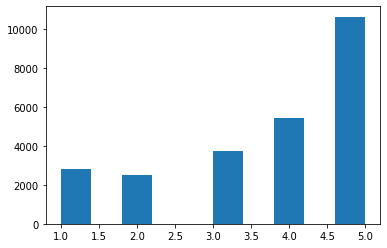

In [24]:
plt.hist(star_train)

(array([ 706.,    0.,  627.,    0.,    0.,  939.,    0., 1361.,    0.,
        2655.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

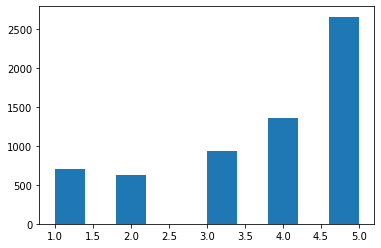

In [25]:
plt.hist(star_test)

In [130]:
DATE = r"([\d]{1,2}[/.-])?[\d]{1,2}[/.-][\d]{4}"
date = re.compile(DATE)

In [132]:
date.match('12-20-2021')

<re.Match object; span=(0, 10), match='12-20-2021'>

In [210]:
remove_telex_error_in_line('Ngực em cuzng bitnhf thường thôi, mà mặc vào nó vừa đẩy vừa sáng cả cái bầu ngực')

'Ngực em cung binh thường thôi, mà mặc vào nó vừa đẩy vừa sáng cả cái bầu ngực'

In [193]:
def remove_telex_error_in_word(word):
    word = re.sub('[wfjzx]', '', word)
    if re.findall('[a-z]s', word):
        word = re.sub('s', '', word)
    if re.findall('[a-z]x', word):
        word = re.sub('x', '', word)
    return word

In [195]:
li = 'tnh'
re.sub(f'{li}', 'alo', 'tnh')

'alo'

In [252]:
consonants = ['b', 'c', 'd', 'đ', 'g', 'h', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'x']
vowels = ['a', 'ă', 'â', 'e', 'ê', 'i', 'o', 'ô', 'ơ', 'u', 'ư', 'y',
          'à', 'ằ', 'ầ', 'è', 'ề', 'ì', 'ò', 'ồ', 'ờ', 'ù', 'ừ', 'ỳ',
          'á', 'ắ', 'ấ', 'é', 'ế', 'í', 'ó', 'ố', 'ớ', 'ú', 'ứ', 'ý',
          'ạ', 'ặ', 'ậ', 'ẹ', 'ệ', 'ị', 'ọ', 'ộ', 'ợ', 'ụ', 'ự', 'ỵ',
          'ẵ', 'ẵ', 'ẫ', 'ẽ', 'ễ', 'ĩ', 'õ', 'ỗ', 'ỡ', 'ũ', 'ữ', 'ỹ',
          'ả', 'ẳ', 'ẩ', 'ẻ', 'ể', 'ỉ', 'ỏ', 'ổ', 'ở', 'ủ', 'ử', 'ỷ']

In [253]:
prefixes = ['ch', 'gh', 'kh', 'ng', 'ngh', 'nh', 'ph', 'th', 'tr']
subfixes = ['ng', 'nh', 'm', 'n', 't']

In [239]:
def remove_miss_type(word):
    for consonant in consonants:
        for prefix in prefixes:
            if prefix == 'ng' and consonant == 'h':
                continue
            word = re.sub(f'{prefix}{consonant}', f'{prefix}', word)
        for subfix in subfixes:
            word = re.sub(f'{consonant}{subfix}', f'{subfix}', word)
    
    for consonant in [instance for instance in consonants if instance not in subfixes]:
        for vowel in vowels:
            sub = ''
            if consonant == 'g':
                sub = 'ng'
            if consonant == 'h':
                sub = 'nh'
            word = re.sub(f'{vowel}{consonant}', vowel+sub, word)
        
    return word

In [256]:
error_correction_in_line('Dat xám gjao xah.thất vọg về sp')

'Dat xám gao xanh.thất vọng về sp'

In [222]:
li = ['1', '2', '3']

In [223]:
li.remove(['1', '2'])

ValueError: list.remove(x): x not in list

In [234]:
remove_miss_type('vọg')

'vọg'

In [254]:
[instance for instance in consonants if instance not in subfixes]

['b', 'c', 'd', 'đ', 'g', 'h', 'k', 'l', 'p', 'q', 'r', 's', 'v', 'x']

In [235]:
remove_accent('ọ')

['o']

In [248]:
remove_miss_type('xám')

'xá'